# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$\\\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)\\$ where 
$\\g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99\\$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pendulum
#import random

In [33]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [34]:
# the next_state function allows to compute the next state given a current state and action
# This is going to be very helpful to run an episode!

# assume we set x = [theta, omega] = [0,0] and u = 5, we can get the next state using
#x = np.array([0.,0.])
#u = 5
#x_next = pendulum.get_next_state(x, u)
#print(f'the next state is {x_next}')

In [35]:
#Discretizing State
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
discretized_omega = np.linspace(-6, 6, 50)

#Intialized variables
epsilon = 0.1
gamma = 0.1 #0.1
alpha = 0.99
controls = np.array([-3,0,3])
timestamp = 100
episodes = 6500 #5000

In [36]:
def get_cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    current_cost = ((theta-np.pi)**2) + (0.01 * theta_dot**2) + (0.0001 * u**2)
    return current_cost

def index_in_discretized_state(state):
    index_in_discretized_theta = np.argmin(np.abs(discretized_theta - state[0]))
    index_in_discretized_omega = np.argmin(np.abs(discretized_omega - state[1]))
    return index_in_discretized_theta, index_in_discretized_omega



In [37]:


def q_learning(q_table,x0):
    x = x0
    get_cost_sum=0
    for t in range(0,timestamp): #100
        #converting state to closest discretized index
        i, j = index_in_discretized_state(x)
        
        # choosing action
        u_t_pre = minimization_and_argument(q_table,i,j)[0]    
        #u_options = [u_t_pre, random.choice(range(len(controls)))]
        u_options = [u_t_pre, np.random.choice([0,1,2])]
        epsilon_probabilities = [1-epsilon, epsilon]
        #u_t = random.choices(u_options, weights=epsilon_probabilities)
        u_t = np.random.choice(u_options, p=epsilon_probabilities)

        
        x_next = pendulum.get_next_state(x,controls[u_t])
        i_next, j_next = index_in_discretized_state(x_next)
        get_cost_sum += get_cost(x,controls[u_t])
        pre_TD_error=(get_cost(x,controls[u_t])) + (alpha * np.min((q_table[u_t,i_next,j_next])))
        q_table[u_t,i,j] = q_table[u_t,i,j] * (1-gamma) + gamma * pre_TD_error
        #q_table[u_t,i,j] = (Q_t[u_t,i,j] + gamma * (get_cost(x,controls[u_t]))) + (alpha * np.min((Q_t[u_t,i_next,j_next]))) - Q_t[u_t,i,j]
        x = x_next
        
    return q_table, get_cost_sum

def get_policy_and_value_function(q_table):    
    value_function = np.zeros((50,50))
    policy = np.zeros((50,50))
    for i in range(len(discretized_theta)):
        for j in range(len(discretized_omega)):
            Q_u, a = minimization_and_argument(q_table,i,j)
            value_function[i,j] = a
            policy[i,j] = controls[Q_u]
            
    return value_function,policy

def minimization_and_argument(q_table,i,j):
    a = q_table[0][i][j]
    Q_u = 0  #Used as index to select control
    for u_i in range(len(controls)):
        b = q_table[u_i][i][j]
        if a > b:
            a = b
            Q_u = u_i
    return Q_u , a
          

In [38]:
# we can also simulate the robot but we need to provide a controller of the following form
q_table = np.zeros((3,50,50))
q_table_next_store = np.zeros((episodes,3,50,50))
cost_sum_store = np.zeros((episodes))

# initial state for the episode
x0 = np.array([0,0])
for n in range(episodes):
    q_table_next,cost_sum = q_learning(q_table,x0)
    q_table_next_store[n][:][:][:] = (q_table_next)
    cost_sum_store[n] = (cost_sum)

value_function,policy = get_policy_and_value_function(q_table_next)  

def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    theta_index,omega_index = index_in_discretized_state(x)
    u= policy[theta_index, omega_index]
    return u


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
#x0 = np.array([1.4,0.])
print(x0)
t, x, u = pendulum.simulate(x0, dummy_controller, T)

[0 0]


In [39]:
#Test Episodes
n1 = np.array([0,0])
n2 = np.array([0,0])

for n in range(episodes-1,0,-1):
    #print(n)
    #if (n< 2700):
    #    q_table_next_store_diff = q_table_next_store[-1][:][:][:] - q_table_next_store[n][:][:][:]
    #    #print(np.allclose(q_table_next_store[-1][:][:][:], q_table_next_store[n][:][:][:], rtol=1e-05,atol=5e1))
    #    #print(q_table_next_store_diff)

    if np.allclose(q_table_next_store[n][:][:][:], q_table_next_store[-1][:][:][:], rtol=100e-05,atol=10e1) == False: #consider atol based on number of iterations
        q_table_next_store_diff = q_table_next_store[-1][:][:][:] - q_table_next_store[n][:][:][:]
        #print(q_table_next_store_diff)
        n2[1]=n
        break

print(f'It takes {n2[1]} episodes for Q-learning to learn how to invert the pendulum.')

It takes 3144 episodes for Q-learning to learn how to invert the pendulum.


C:\Users\fejio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
C:\Users\fejio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\fejio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'Episode')

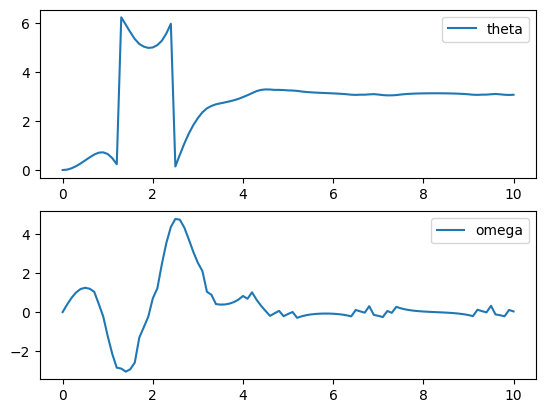

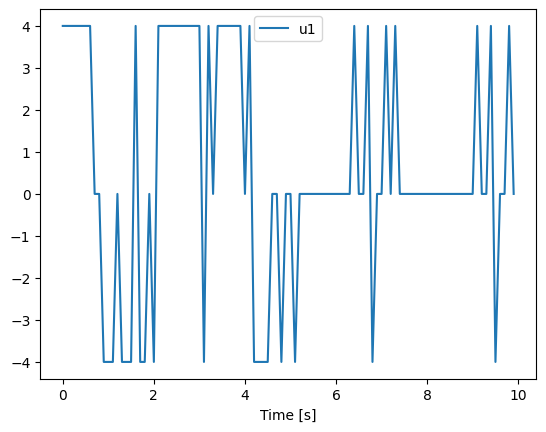

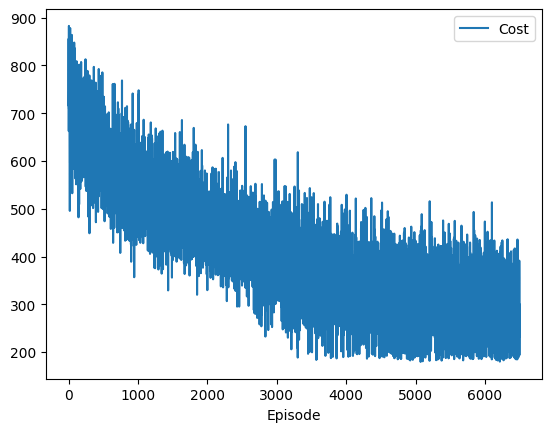

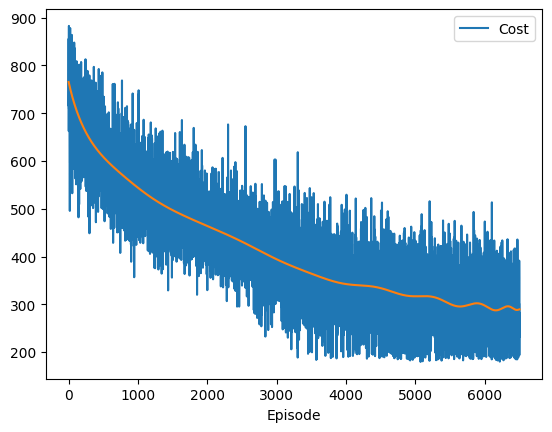

In [40]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

#Learning Progress Plot
plt.figure()
plt.plot(range(episodes),cost_sum_store)
plt.legend(['Cost'])
plt.xlabel('Episode')

#Extra Plot with curve fitting
z = np.polyfit(range(episodes), cost_sum_store, 80)
p = np.poly1d(z)
#p30 = np.poly1d(np.polyfit(range(episodes), cost_sum_store, 30))
xp = np.linspace(0, episodes, episodes+1)

plt.figure()
#plt.plot(range(episodes), cost_sum_store, '-', xp, p(xp), '-', xp, p30(xp), '--')
plt.plot(range(episodes), cost_sum_store, '-', xp, p(xp), '-')
plt.legend(['Cost'])
plt.xlabel('Episode')

In [41]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAiMFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwMSBiMDkzYmJlIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DR9liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI9z6B9hJKucXbnulv0Tx3pgWGkq4zCJoUSDQbMTKpHP
1+uP9z8QZom84f5DU6BeXVvtHm4djF23BlQKdhX2EUStmmG6N08XGoAVuMW72rKKVN6VdHRgsHNr
x3MR4qDMgAxERdUoQ7BXRJr4BX5soPZq/wcjolq6sTi1OvLDBtyBLPszN6tiPcUaMheYx0iV67aE
zZf/BUqm/lhAt8bzKYdsJ9/lcztqCxibPrNj5oyGn3C0REKARQj2zVOcjGQ+FMzZO2661ZGQyDFz
iir12w0bCCrErPPWnwawwtU4EcDyMcfy1O9nup++LMTj/9v5cGKwseLrqDKDLRy72SeWx0X1PS2r
gB5EoiitXz2syX3fZtL7eXGNp9LGfmQZvNn/8kQNYLyikrHwFtnL/NwLzzF1wqLYpRm7lnQcAK08
DUly7RKGunCX7cfEaLO2YLdetEUtN+WGIMUegtlA0WxNBo4/aPhcbdhXK0nhVZKAO7NT/QAL/+Yx
5BkLt8cfKDySgqLF75BgIOUJh0ib2PPpoocKe2KEjR7SCjS2rxPtgBk2EXdhJD5Q2wXu/c9rCths
1jSEGuSqEwVxO7GbN19+LNdEa9TvZlhcscfGQcr0yhOHKsmiGhqJXqcixubXTLuyPWkcX7k2y2mk
SmFv+M3h7BW8F8KyBtq+Susbt7S0KcrnNmgI7a59R9NBWHNU2bzFf8MQL0DbBmYb3ZYdYDlj1z7H
2Qf+Sp7Me+IA72yWlBvkbG+q5OnsXciOKIm/0kDkHxZKVyTv6H2zwetzn8NnvSF1gPu4vS2WLrv7
2U+rltICVC7VC3WxB1hTBYYE1Lp9R29nUfzXI2ZIwpP5I2Q9qUshCM4UEoAYsFNuMuD0FyW4qrs5
E8PRrLfmd1SyZMcr3n9XEsCMtontispemBQdHTxb/4FbJhxL54BcaLXTMdcX+QYoVEuEwWDQB4wT
m/Mw1dlin5dv0BbH7re+L4UNFAgSi+MIAtlSWemYp+mstcRpTRfyAm4qtIezzxb43jyvwegmn5TB
mYXj4x+HlmTOmWcYpOEwUj+VJllyxMjpU8PRo/uS8+1zSr6zYXLd3kjo4mWYD6VODmPCro7aDKKQ
oBtETQbno9GYgni9jb4aJBrKUV1lTfH48zXuCngqaa11arQoik//PluX83qpG4BL7Qlf8GtouEqE
+QSgcFKgaB77MJkTxka4PXtR7mlIFEMHGbphubGK9SXcjYYV9+Ww28K/nGQ0Xe6Ysls9EnW63FtL
p2wyseafy+uPS0gumno3PHx4MkvgawRlTkzr3vv4YM7C+utWDjTsrA1BxIdS5E8M1kvDv7Z7EnQV
d0d70gzwgT58wwfJZ1HGqUqcOEyFxIesSJ2b3Iky/J23uigvTsSouvJsQu1ou/u0sLpt/3aJAmXO
T9l2VdjHr9na9ITCAXNZztUVF4X/cb7DVIa798lhOMv1bHtEidb4f2YWT0nfpVpiX+pygBClLvkc
dSFyxdIbbdhuiXcU+tqtGzZrIXBQTv/zIMwS4WLvefj8oNbV2IvIXLU9q7fzGnkH0rPKdUWFk54C
IE0j//QsJjEN+VDIgeSstKBxSLcdDv9w2TXnu7HmTyu9TSec84FzGL6NIVZlwBUKQAN08Qlbjrmh
h1m4sfNRM/1gdyrz546sQpeofLomXrwCbH6MqugI6NKUeWfPLo4AAWLP29pYsZ7NA5RP/UkbiZbw
UT03ZFK8hCRfV6AYX3KQxuec8kGEZF8XDccaHDPleiSlqryP0s334DOdkwD86stIFtQzgpM5zzfq
kg5m7ZJuMlc/d+f6TobUOcmrP8Wr1MTcQR57W9dOFMZ7Dk2ts6smp56l7o1HKc1LPaW+YOith8X2
xz8JK+xRALOOvU9+hFPTKFXvbmyic1kyU+n6XS0ZsgMB0x9D9YDmMtI/K4gAbXyVCdFmtm/Q6HXM
ytTD47p6va4IUvmfFnU/Ffar1yKEqvxhFxaK4lb7DJL5SPHHdFzwcTS8mN2E+izgkCR+jtDrOahF
WGw228t433ndN0UKztv7tZg5NT4z30UWyTmXRaqx/4Im678jJNh7IJ5+Tiy2qnNIEvp6hMgD84UG
mKOYbi+LuZvwE1OQzWCXDn/rQU/afEquTk2Rii8/fqDimrTSqCuBEMeTRp+jbYpIg4SG3mxeTLWi
5X88bYW6awrUDNELRUNo8

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

In [42]:
# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)

# now given an arbitrary continuous state theta
theta_arbitrary = 0.6234
omega_arbitrary = 1.234

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))
index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))

# and find the closed discretized state
closest_theta_state = discretized_theta[index_in_discretized_theta]
closest_omega_state = discretized_omega[index_in_discretized_omega]

print(f'the discretized theta closest to {theta_arbitrary} is {closest_theta_state} with index {index_in_discretized_theta}')
print(f'the discretized omega closest to {omega_arbitrary} is {closest_omega_state} with index {index_in_discretized_omega}')

the discretized theta closest to 0.6234 is 0.6283185307179586 with index 5
the discretized omega closest to 1.234 is 1.3469387755102042 with index 30


Text(0.5, 1.0, 'Policy')

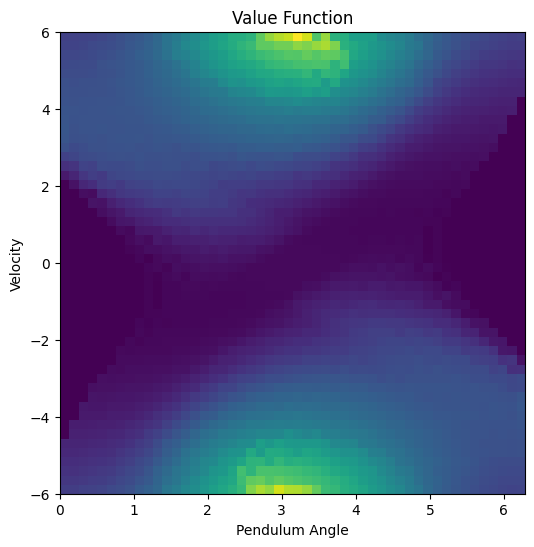

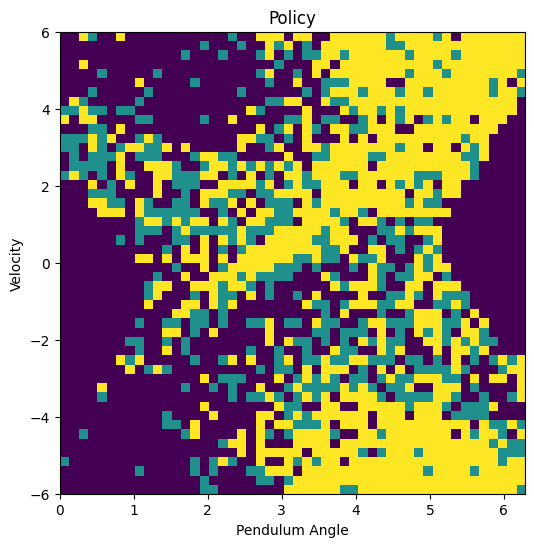

In [43]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')